Stochastic Volatilty Models

#### Home work 1

---

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol HW1". WARNING: topic is important! Inbox will be filtered automatcally based on exact match. Please zip all files into one folder and rename it as "SurnameName_HW1" before sending.

Deadline: 2nd of November, 23:59.

If you have any questions feel free to ask in Telegram https://t.me/v_antipov or https://t.me/igortao.

Full name:  Cherepakhin Ivan

Faculty: MMF MSU

---

In [2]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats  
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [3]:
DARK_THEME = True

if DARK_THEME:
    plt.style.use("dark_background")
    mpl.rcParams["figure.facecolor"] = "none"
    mpl.rcParams["axes.facecolor"] = "none"

### Problem 1 (20 points)

**1**. 💅 <span style="color:blue">(5 points)</span>  Calculate and plot **put** option prices in Black-Scholes model as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters 

$$K = 1, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

In [4]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

In [5]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

In [6]:
def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [7]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

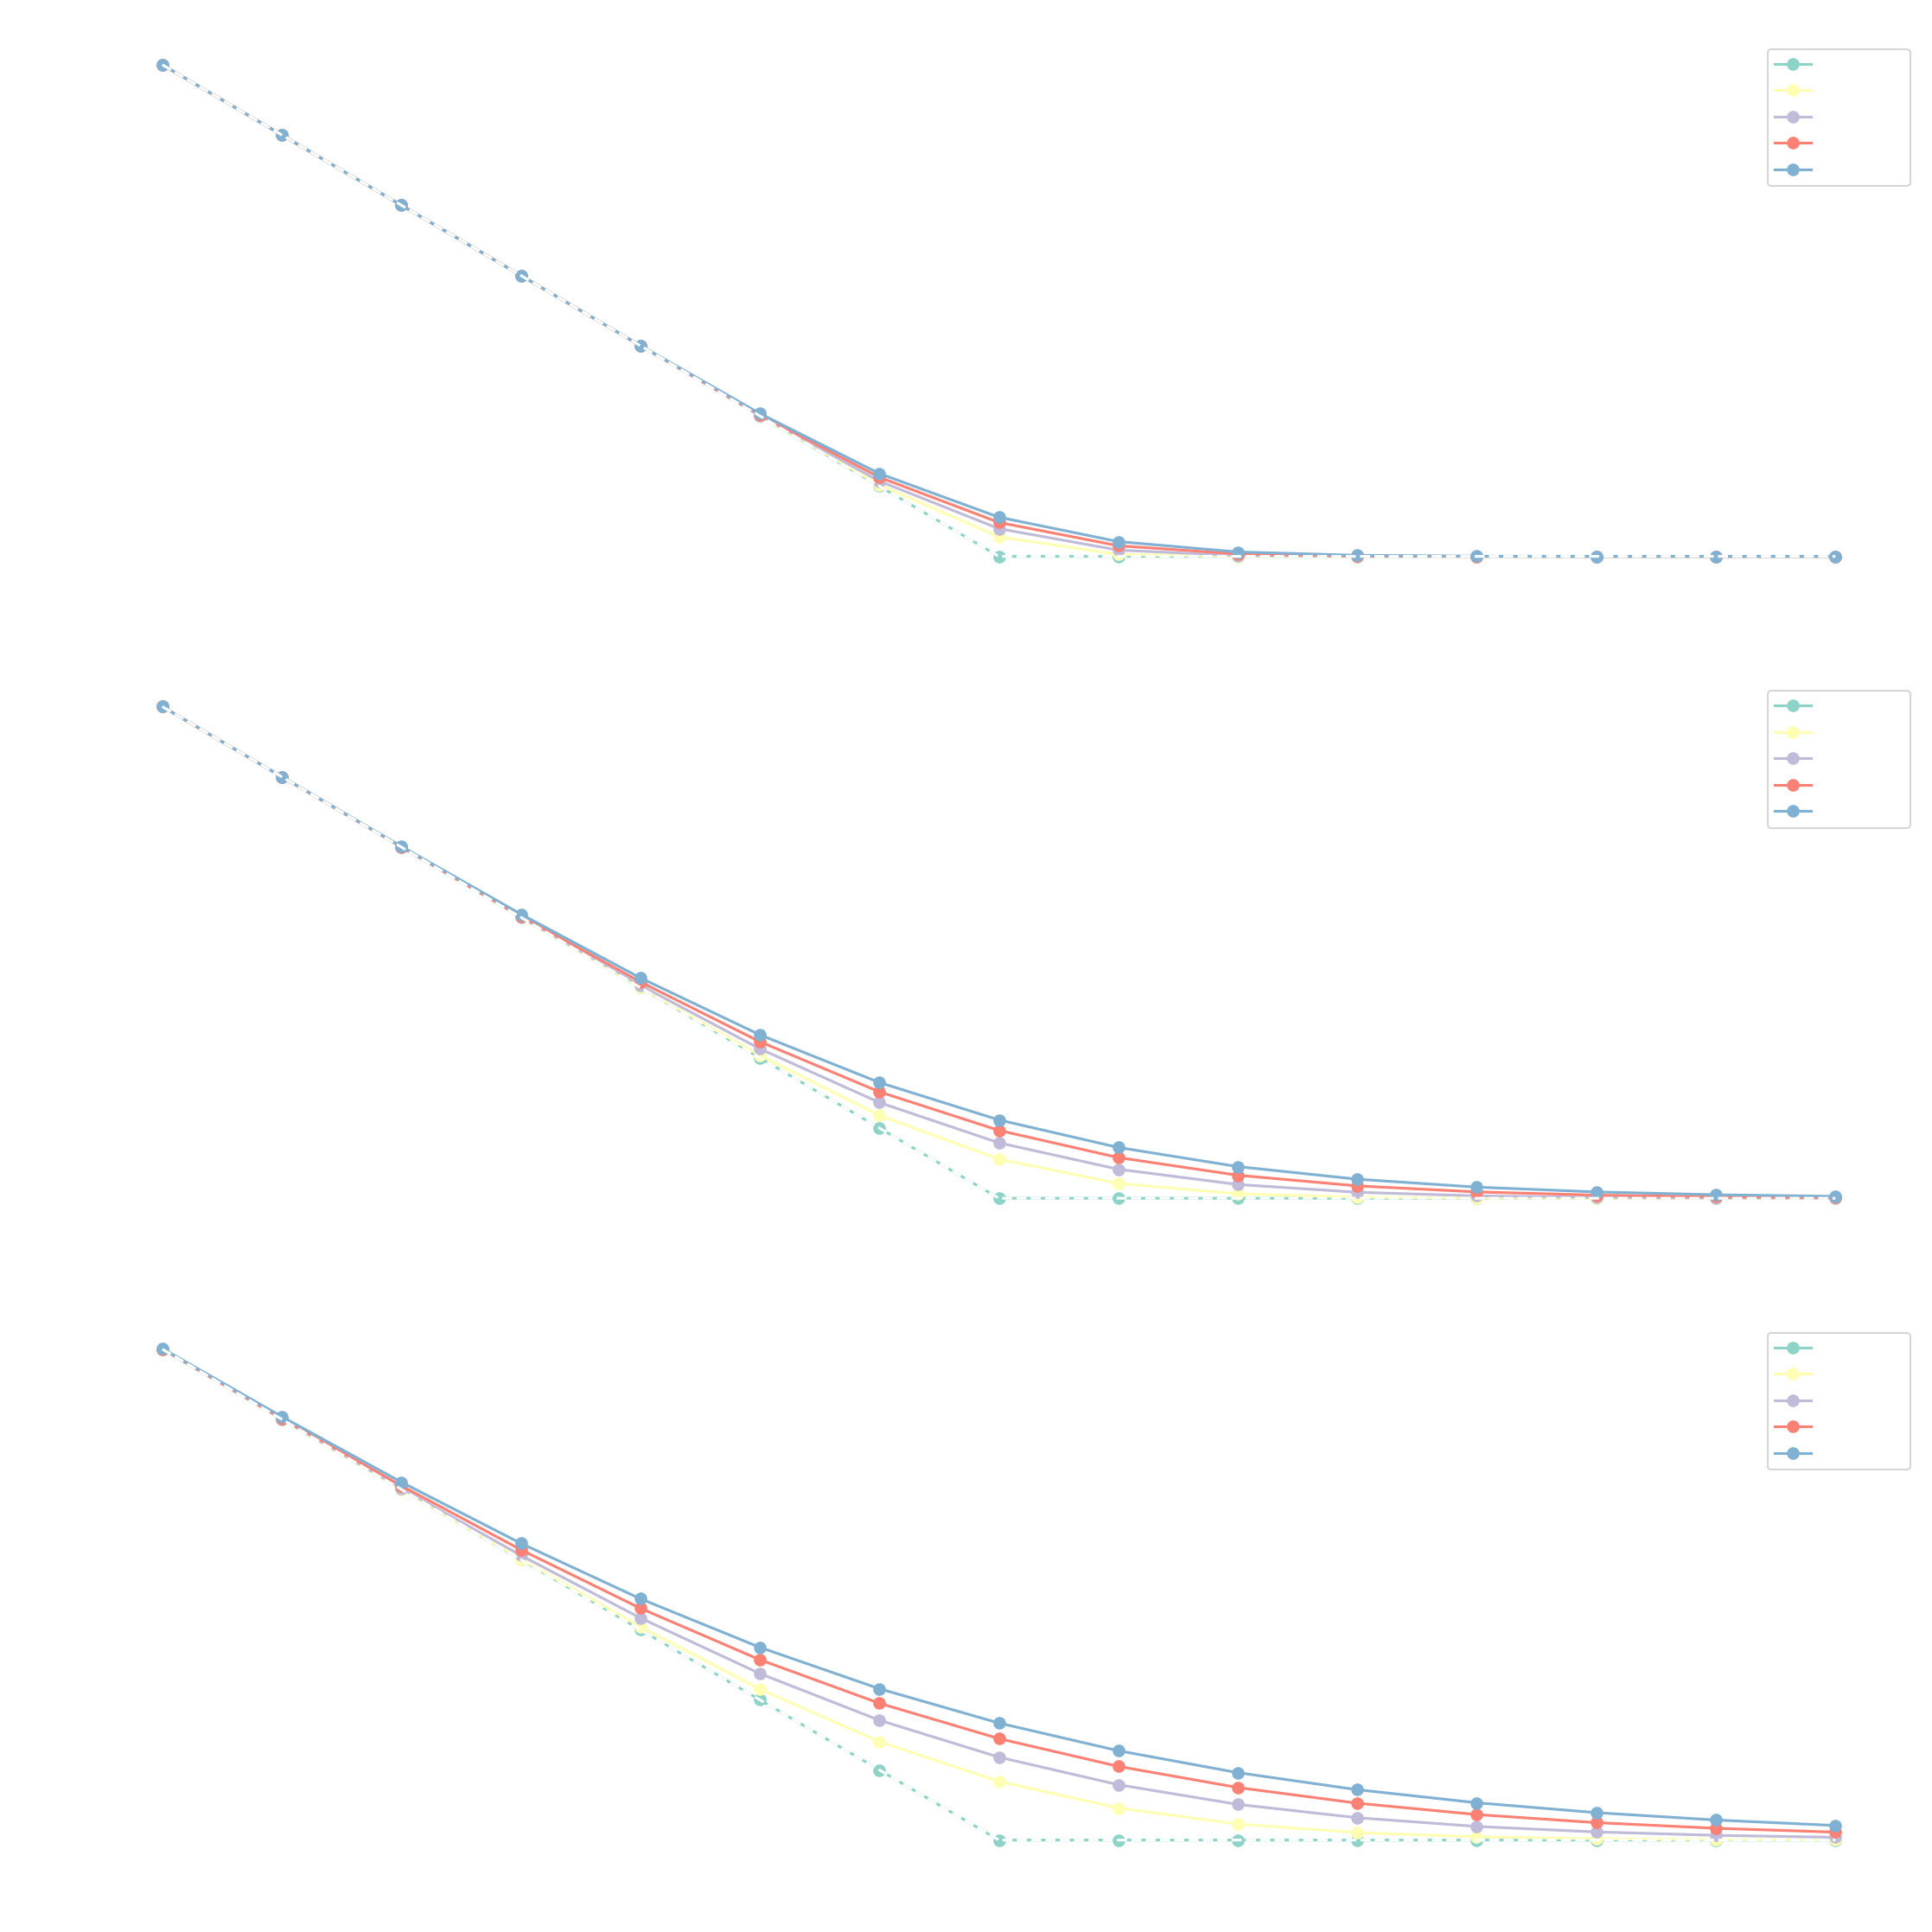

In [45]:
r = 0
S_ax = np.linspace(0.5, 1.5, 15)
S = 1
Sigma = [0.1, 0.2, 0.3]

K = 1
times = np.linspace(0, 1, 5)

puts = PutStockOption(strike_price=K,
                      expiration_time=times[:, None])

ms = MarketState(stock_price=S_ax, interest_rate=r)

fig, axs = plt.subplots(nrows=3, figsize=(15, 15), dpi=150)


for (sigma, ax) in zip(Sigma, axs):
    params = BSParams(volatility=sigma)
    ax.plot(S_ax, price(puts, ms, params).T, "o-", label=list(map(lambda x : "T = " + str(x) , times)))
    ax.plot(S_ax, [max(K - s, 0) for s in S_ax], color="white", linestyle="--")
    ax.set_title(f"Sigma = {sigma}")
    ax.set_xlabel("Time, years")
    ax.set_ylabel("Price put option, $")
    ax.legend()

# fig.supxlabel("Time, years")
plt.tight_layout()
plt.show()


**2**. 💅 <span style="color:blue">(5 points)</span>  What kind of dependence on the parameters of put option price do you observe? How does the price of a put option change with changes in volatility, time to expiration? Why? Provide the intuition. 

Первое наблюдение, что при большем времени экспирации цена опциона растет(интуиция - больше вероятность исполнения => цена больше). Также из графика(соответственно из формул) видно, что есть зависимость между ценой и волатильностью, причем чем больше волатильность тем больше цена. Интуиции кроется в том, что волатильность является некоторым индикатором интенсивности цены. Соответсвенно чем она больше, тем больше ее колебания. Таким образом вероятность исполнения контракта возрастает, что влечет за собой увелечение цены опциона.

**3**. 💅 <span style="color:blue">(10 points)</span> Replicate considered put option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.


*Note: use $m = 2^{10} - 1$ and $n$ = 123*. 

In [9]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 200,
):
    
    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

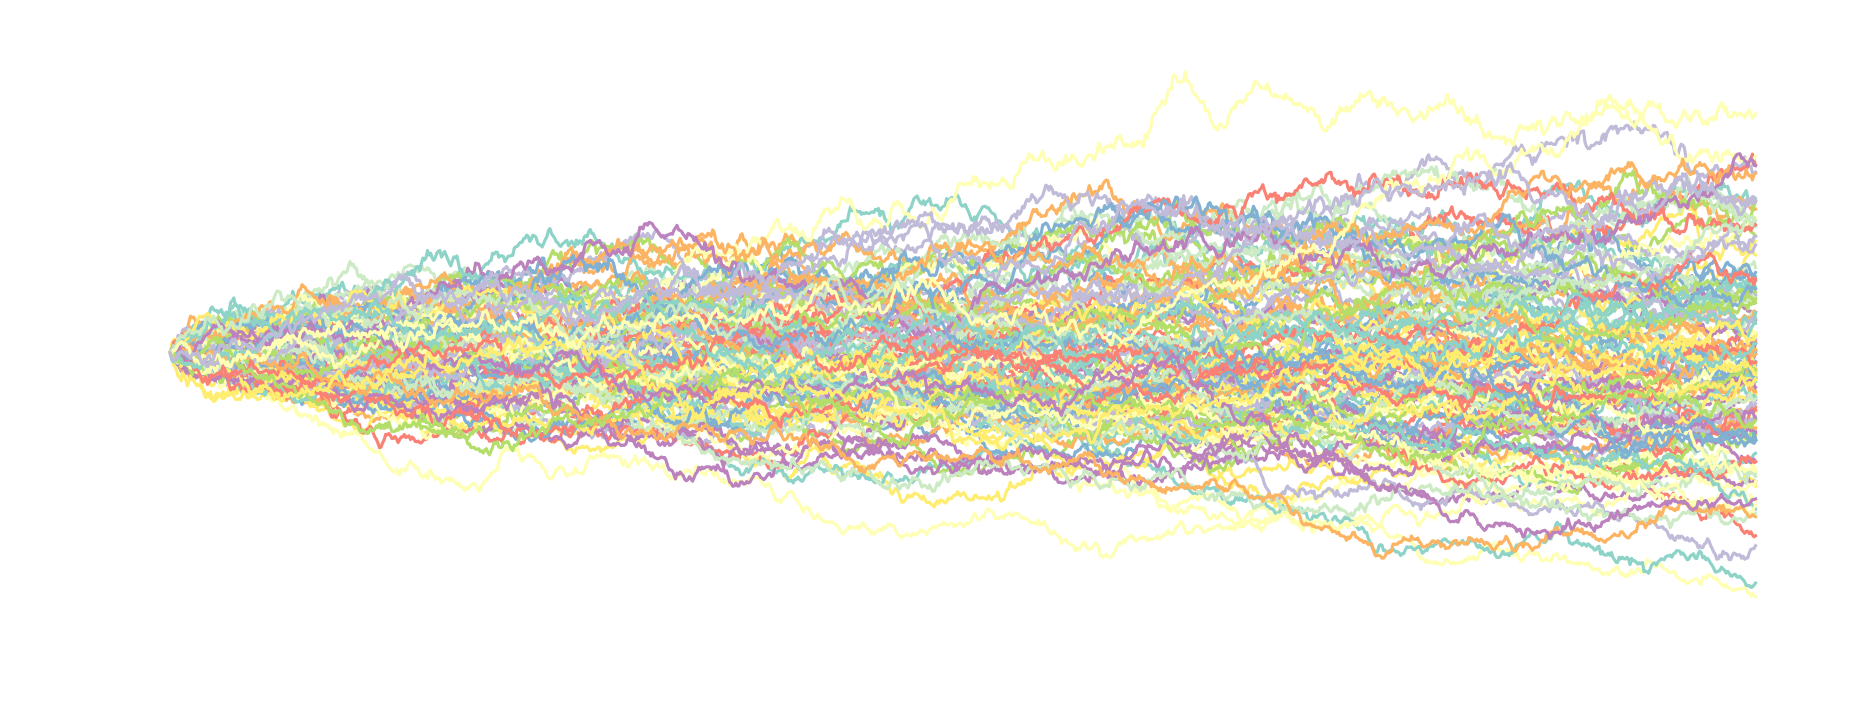

In [10]:
n = 123
m = 2**10 - 1
T = 1.0

ms = MarketState(stock_price=1, interest_rate=0.0)
params = BSParams(volatility=0.1)
sim_fn = make_bsm_market_simulator(ms, params, T, m)
paths = sim_fn(n)
t = np.linspace(0, T, m + 1)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the BSM model")
plt.show()

In [11]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 200,
    n_paths: int = 1000,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params)
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [12]:
option = PutStockOption(strike_price=1.0, expiration_time=1.0)
ms = MarketState(stock_price=1.0, interest_rate=0.0)
params = BSParams(volatility=0.1)

In [13]:
pl = -calc_hedging_pnl(
    option,
    ms,
    params,
    n_paths=n,
    n_steps=m,
    seed=42,
).sum(-1)

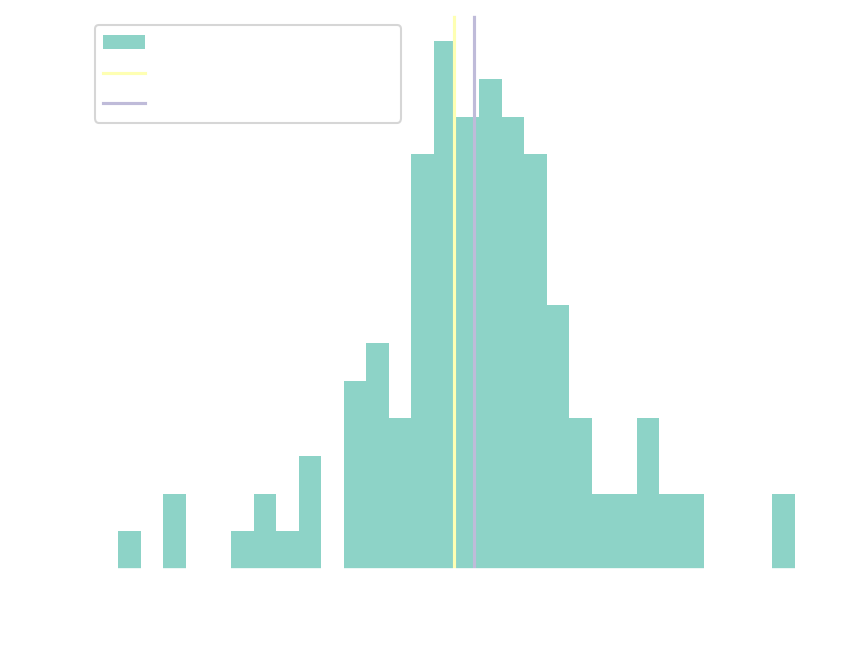

In [14]:
p = price(option, ms, params)

_, ax = plt.subplots(dpi=150)
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.legend()
plt.show()

---

### Problem 2 (30 points)

**1**. 🧠 <span style="color:blue">(15 points)</span>  Consider the market with one riskless asset $B_t \equiv 1$ and risky asset $S_t$, given by the equations

$$dS_t = S_t (\mu dt + \sigma_t dW_t^{1}), \quad S_0 = 1,$$
$$\sigma_t = 1  + |W_t^{2}|,$$

where $W_t^{1}$ and $W_t^{2}$ are independent Brownian motions.

Prove that the market is not complete and provide an example of non-replicable bounded contingent claim.

YOUR ANSWER HERE

**2**. 🧠 <span style="color:blue">(15 points)</span>  For the model from the previous question find an equivalent martingale measure and calculate its Radon-Nikodym derivative with respect to the initial measure $P$.

![Getting Started](two.jpeg)

---

### Problem 3 (20 points)

Consider the no-arbitrage market consisting of risk-free asset $B_t$ with constant interest rate $r$ and risky asset $S_t > 0, t \in [0, T]$. Let $Q$ be a EMM for this market. 

🧠 <span style="color:blue">(10 points)</span> Show that for an arbitrage-free price of European call option 

$$C = \frac{B_0}{B_T} \mathbb{E}^{Q} (S_T - K)_{+}$$

the following representation holds

$$C = S_0 \tilde Q (S_T \geq K) - \frac{B_0}{B_T} K Q(S_T \geq K),$$

where $\tilde Q$ is some probability measure equilvanet to $Q$. 
  

<!-- ![Getting Started](./three_1.jpeg) -->
![Getting Started](three.jpeg)

🧠 <span style="color:blue">(10 points)</span> Find the density $d \tilde Q / dQ$ and show that the process $B_t/S_t$ is a martingale with respect to $\tilde Q$. 

YOUR ANSWER HERE

---

### Problem 4 (30 points)

Suppose the spot stock price and the price of the bond with maturity $T$ have the following dynamics under $ \tilde P$:

$$dB(t,T)=r_t B(t,T)dt + \sigma_t^{B} B(t,T) dW_t^{B}, \quad dS_t =(r_t −q_t)S_tdt + \sigma_t^{S} S_t dW_t^{S},$$
where $r_t$, $q_t$, $\rho_t$, $\sigma_t^{B}$, $\sigma_t^{S}$ are some random processes, and $W^{B}$, $W^{S}$ are correlated
Brownian motions, $dW_t^{B}dW_t^{S} = \rho_tdt$. 

🧠 <span style="color:blue">(15 points)</span>  Show that for the T-forward price $F_t$ we have 

$$ \frac{dF_t}{F_t} =\mu_t^{F} dt + \sigma_t^{F} dW_t^{F},$$

where 

$$\mu_t^{F} = \sigma_t^{B} (\sigma_t^{B} - \rho_t \sigma_t^{S}) - q_t, \quad \sigma_t^{F} = \sqrt{(\sigma_t^{S})^2 - 2 \rho_t \sigma_t^{S} \sigma_t^{B} + (\sigma_t^{B})^2}, \quad dW_t^{F} = \frac{1}{\sigma_t^{F}}(\sigma_t^{S} dW_t^{S} - \sigma_t^{B} dW_t^{B}).$$
 
*Hint*: apply Ito's formula to $S_t = B(t, T) F_t.$

YOUR ANSWER HERE

🧠 <span style="color:blue">(15 points)</span> Show that under the forward measure $Q^T$ associated with $\tilde P$ by the Radon-Nikodym derivative 

$$Z_t := \frac{dQ^{T}_t}{d \tilde P_t} = \frac{B(t, T) / B_t}{B(0, T) / B_0},$$


we have 

$$ dF^{T}_t = \sigma_t^{F} F^{T}_t d\tilde W_t^{F}, $$
$$d B(t, T) = \mu_t^{B} B(t, T) dt + \sigma_t^{B} B(t, T) d \tilde W_t^{B},$$
$$dS_t = \mu_t^{S} S_t dt + \sigma_t^{S} S_t d \tilde W_t^{S},$$

where $\tilde W^{F}, \tilde W^{B}, \tilde W^{S}$ are Brownian motions and 

$$\mu_t^{B} = r_t + (\sigma_t^{B})^2,$$
$$\mu_t^{S} = r_t - q_t + \rho_t \sigma_t^{S} \sigma_t^{B},$$
$$\sigma_t^{S} = \rho_t \sigma_t^{B} + \sqrt{(\sigma_t^{F})^{2} - (1 - \rho_t^{2}) (\sigma_t^{B})^2}.$$

![Getting Started](four_1.jpeg)
![Getting Started](four_2.jpeg)